# Sign Language Detection V8


## Data and Preprocessing 

In [1]:
# tensor flow with gpu

import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 0 for GPU
                                         # -1 for CPU
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [2]:
# importing dependencies

import numpy as np  # linear algebra
import pandas as pd  # dataset handling
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import tensorflow as tf # tensorflow
import cv2 # computer vision
import os # interacting with the operating system

from tensorflow.keras import Sequential # squential neural network
from tensorflow.keras.layers import Conv2D  # convolutional layer
from tensorflow.keras.layers import MaxPool2D  # pooling layer
from tensorflow.keras.layers import Dense # feed forward layer
from tensorflow.keras.layers import Flatten # flatten 2d/3d array into 1d array
from tensorflow.keras.layers import Dropout # print overfitting
from tensorflow.keras.callbacks import EarlyStopping # early stopping to reduce overfitting
from tensorflow.keras.utils import plot_model # plot model architecture
from tensorflow.keras.models import load_model # loading saved model

from sklearn.preprocessing import LabelEncoder # add placeholder values for categorical variables
from sklearn.model_selection import train_test_split # split dataset into training and testing dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # performance metrics

### Train data

In [3]:
# extracting files, images and labels 

train_path = r'C:\Users\dariu\Jupyter_Notebook\Sign Language Detection\sign_language_detection_dataset\train'

filename_list = []
image_list = []
label_list = []
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for label in labels:
    for filename in os.listdir(train_path+f'\\{label}'):
        file_path = train_path+f'\\{label}'+f'\\{filename}'
        letter = label
        image = cv2.imread(file_path)
        filename_list.append(filename)
        image_list.append(image)
        label_list.append(letter)

In [4]:
# creating meta dataset contiaing filenames, labels, and image

meta_data = pd.DataFrame({'filename':filename_list, 'label':label_list, 'image':image_list})
print(meta_data.shape)
meta_data.head()

(47412, 3)


,filename,label,image
0,0.jpg,A,"[[[184, 181, 177], [186, 183, 179], [189, 186,..."
1,1.jpg,A,"[[[184, 182, 174], [184, 182, 174], [184, 182,..."
2,10.jpg,A,"[[[183, 182, 172], [184, 183, 173], [186, 185,..."
3,100.jpg,A,"[[[191, 187, 176], [188, 184, 173], [188, 183,..."
4,1001.jpg,A,"[[[172, 170, 176], [171, 169, 175], [167, 165,..."


In [5]:
# number of of samples per letter (category)

meta_data['label'].value_counts()

C    1861
G    1860
E    1839
A    1836
Z    1835
K    1834
S    1830
T    1825
H    1825
F    1821
D    1820
Q    1820
Y    1820
U    1818
P    1818
R    1817
J    1817
O    1817
W    1815
X    1815
I    1815
M    1815
L    1811
V    1810
B    1810
N    1808
Name: label, dtype: int64

In [6]:
# shuffling meta dataset

meta_data =meta_data.sample(frac=1).reset_index(drop=True)
meta_data.head()

,filename,label,image
0,441.jpg,R,"[[[183, 180, 176], [183, 180, 176], [184, 181,..."
1,681.jpg,F,"[[[170, 171, 167], [172, 173, 169], [173, 174,..."
2,934.jpg,V,"[[[169, 167, 166], [166, 164, 163], [175, 173,..."
3,28.jpg,M,"[[[185, 185, 185], [185, 185, 185], [185, 185,..."
4,2516.jpg,F,"[[[184, 183, 179], [185, 184, 180], [186, 185,..."


In [7]:
# function that preprocesses the data

def preprocess_image(image):
    """Takes in image array as input and returns resized and scaled image"""
    image = cv2.resize(image, (64,64))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(64,64,1)
    image = image.astype('float32')/255.0
    return image

In [8]:
# preprocessing the images

preprocessed_image_list = []
for image in meta_data['image']:
    img = preprocess_image(image)
    preprocessed_image_list.append(img)

In [9]:
meta_data['preprocessed_image'] = preprocessed_image_list
meta_data.head()

,filename,label,image,preprocessed_image
0,441.jpg,R,"[[[183, 180, 176], [183, 180, 176], [184, 181,...","[[[0.7019608], [0.7176471], [0.7254902], [0.78..."
1,681.jpg,F,"[[[170, 171, 167], [172, 173, 169], [173, 174,...","[[[0.6784314], [0.6784314], [0.7019608], [0.75..."
2,934.jpg,V,"[[[169, 167, 166], [166, 164, 163], [175, 173,...","[[[0.65882355], [0.65882355], [0.6509804], [0...."
3,28.jpg,M,"[[[185, 185, 185], [185, 185, 185], [185, 185,...","[[[0.7294118], [0.73333335], [0.74509805], [0...."
4,2516.jpg,F,"[[[184, 183, 179], [185, 184, 180], [186, 185,...","[[[0.7176471], [0.7254902], [0.75686276], [0.7..."


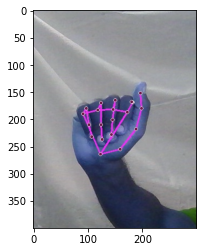

In [10]:
# sample image

plt.imshow(image_list[5])

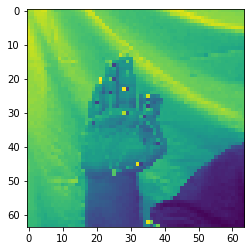

In [11]:
# sample preprocessed image 

plt.imshow(preprocessed_image_list[4])

In [12]:
# splitting meta dataset into inputs and targets

X_train = np.array(preprocessed_image_list)

le = LabelEncoder() 
y_train = meta_data['label'] # adding number placeholders for each category
y_train = le.fit_transform(y_train)

In [13]:
print(X_train.shape, y_train.shape)

(47412, 64, 64, 1) (47412,)


### Validation data

In [14]:
# extracting files, images and labels 

validation_path = r'C:\Users\dariu\Jupyter_Notebook\Sign Language Detection\sign_language_detection_dataset\valid'

filename_list = []
image_list = []
label_list = []
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for label in labels:
    for filename in os.listdir(validation_path+f'\\{label}'):
        file_path = validation_path+f'\\{label}'+f'\\{filename}'
        letter = label
        image = cv2.imread(file_path)
        filename_list.append(filename)
        image_list.append(image)
        label_list.append(letter)

In [15]:
# creating meta dataset contiaing filenames, labels, and image

val_meta_data = pd.DataFrame({'filename':filename_list, 'label':label_list, 'image':image_list})
print(val_meta_data.shape)
val_meta_data.head()

(9463, 3)


,filename,label,image
0,1000.jpg,A,"[[[169, 170, 174], [173, 174, 178], [172, 173,..."
1,1007.jpg,A,"[[[164, 165, 169], [168, 169, 173], [169, 170,..."
2,1014.jpg,A,"[[[160, 163, 168], [162, 165, 170], [165, 165,..."
3,1021.jpg,A,"[[[168, 172, 173], [166, 170, 171], [165, 169,..."
4,1028.jpg,A,"[[[171, 170, 179], [173, 172, 181], [167, 167,..."


In [16]:
# number of of samples per letter (category)

val_meta_data['label'].value_counts()

C    372
G    371
E    367
A    367
Z    366
K    366
S    365
H    364
F    364
T    364
D    363
P    363
O    363
U    363
R    363
Q    363
Y    363
J    363
L    362
M    362
W    362
I    362
X    362
B    361
N    361
V    361
Name: label, dtype: int64

In [17]:
# shuffling meta dataset

val_meta_data =val_meta_data.sample(frac=1).reset_index(drop=True)
val_meta_data.head()

,filename,label,image
0,727.jpg,Z,"[[[175, 175, 175], [170, 170, 170], [173, 173,..."
1,1364.jpg,J,"[[[179, 183, 178], [181, 185, 180], [179, 183,..."
2,2162.jpg,C,"[[[177, 178, 174], [176, 177, 173], [177, 178,..."
3,832.jpg,V,"[[[172, 174, 168], [163, 165, 159], [169, 171,..."
4,2519.jpg,M,"[[[185, 180, 182], [183, 178, 180], [183, 178,..."


In [18]:
preprocessed_image_list = []
for image in val_meta_data['image']:
    img = preprocess_image(image)
    preprocessed_image_list.append(img)

In [19]:
# splitting meta dataset into inputs and targets

X_val = np.array(preprocessed_image_list)

y_val = val_meta_data['label'] # adding number placeholders for each category
y_val = le.transform(y_val)

In [20]:
print(X_val.shape, y_val.shape)

(9463, 64, 64, 1) (9463,)


In [21]:
val_meta_data['preprocessed_image'] = preprocessed_image_list
val_meta_data.head()

,filename,label,image,preprocessed_image
0,727.jpg,Z,"[[[175, 175, 175], [170, 170, 170], [173, 173,...","[[[0.6862745], [0.68235296], [0.6666667], [0.6..."
1,1364.jpg,J,"[[[179, 183, 178], [181, 185, 180], [179, 183,...","[[[0.7137255], [0.69411767], [0.6901961], [0.6..."
2,2162.jpg,C,"[[[177, 178, 174], [176, 177, 173], [177, 178,...","[[[0.7019608], [0.7254902], [0.74509805], [0.7..."
3,832.jpg,V,"[[[172, 174, 168], [163, 165, 159], [169, 171,...","[[[0.67058825], [0.654902], [0.6509804], [0.63..."
4,2519.jpg,M,"[[[185, 180, 182], [183, 178, 180], [183, 178,...","[[[0.69803923], [0.72156864], [0.74509805], [0..."


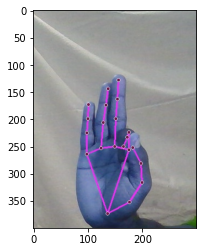

In [22]:
# sample image

plt.imshow(image_list[1900])

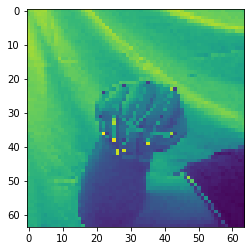

In [23]:
# sample preprocessed image 

plt.imshow(preprocessed_image_list[4])

## Model Training

In [24]:
# INPUT_SHAPE and OUTPUT_SHAPE hyperparameters

INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = len(labels)
print(INPUT_SHAPE, OUTPUT_SHAPE)

(64, 64, 1) 26


In [25]:
# # creating CNN model with activation relu
# # output layer activation is softmax as this is a multiclassification model

# model = Sequential()
# model.add(Conv2D(32, (2,2), activation='relu', input_shape=INPUT_SHAPE))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.1))

# model.add(Conv2D(64, (2,2), activation='relu'))
# model.add(MaxPool2D(2,2))
# model.add(Dropout(0.1))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPool2D(2,2))
# model.add(Flatten())
# model.add(Dropout(0.3))
# model.add(Dense(70, activation='relu'))
# model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

In [26]:
# creating CNN model with activation relu
# output layer activation is softmax as this is a multiclassification model

model = Sequential()
model.add(Conv2D(32, (2,2), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.7))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.7))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(70, activation='relu'))
model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

In [27]:
# configuring early stopping to avoid overfitting

es = EarlyStopping(monitor='accuracy', patience=1, restore_best_weights=True)

In [28]:
# using adam as optimizer and sparse_categorical_crossentropy as loss function

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
# training the model

hist = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val,y_val), verbose=2, callbacks=[es])

Epoch 1/15
1482/1482 - 25s - loss: 2.1123 - accuracy: 0.3583 - val_loss: 0.9067 - val_accuracy: 0.7601 - 25s/epoch - 17ms/step
Epoch 2/15
1482/1482 - 8s - loss: 0.5489 - accuracy: 0.8167 - val_loss: 0.2967 - val_accuracy: 0.9379 - 8s/epoch - 5ms/step
Epoch 3/15
1482/1482 - 8s - loss: 0.3239 - accuracy: 0.8905 - val_loss: 0.1444 - val_accuracy: 0.9734 - 8s/epoch - 5ms/step
Epoch 4/15
1482/1482 - 8s - loss: 0.2529 - accuracy: 0.9141 - val_loss: 0.0998 - val_accuracy: 0.9849 - 8s/epoch - 5ms/step
Epoch 5/15
1482/1482 - 8s - loss: 0.2048 - accuracy: 0.9302 - val_loss: 0.0675 - val_accuracy: 0.9924 - 8s/epoch - 5ms/step
Epoch 6/15
1482/1482 - 8s - loss: 0.1781 - accuracy: 0.9399 - val_loss: 0.0630 - val_accuracy: 0.9917 - 8s/epoch - 5ms/step
Epoch 7/15
1482/1482 - 8s - loss: 0.1613 - accuracy: 0.9443 - val_loss: 0.0386 - val_accuracy: 0.9951 - 8s/epoch - 5ms/step
Epoch 8/15
1482/1482 - 8s - loss: 0.1457 - accuracy: 0.9519 - val_loss: 0.0455 - val_accuracy: 0.9958 - 8s/epoch - 5ms/step
Epoch

In [30]:
# summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0

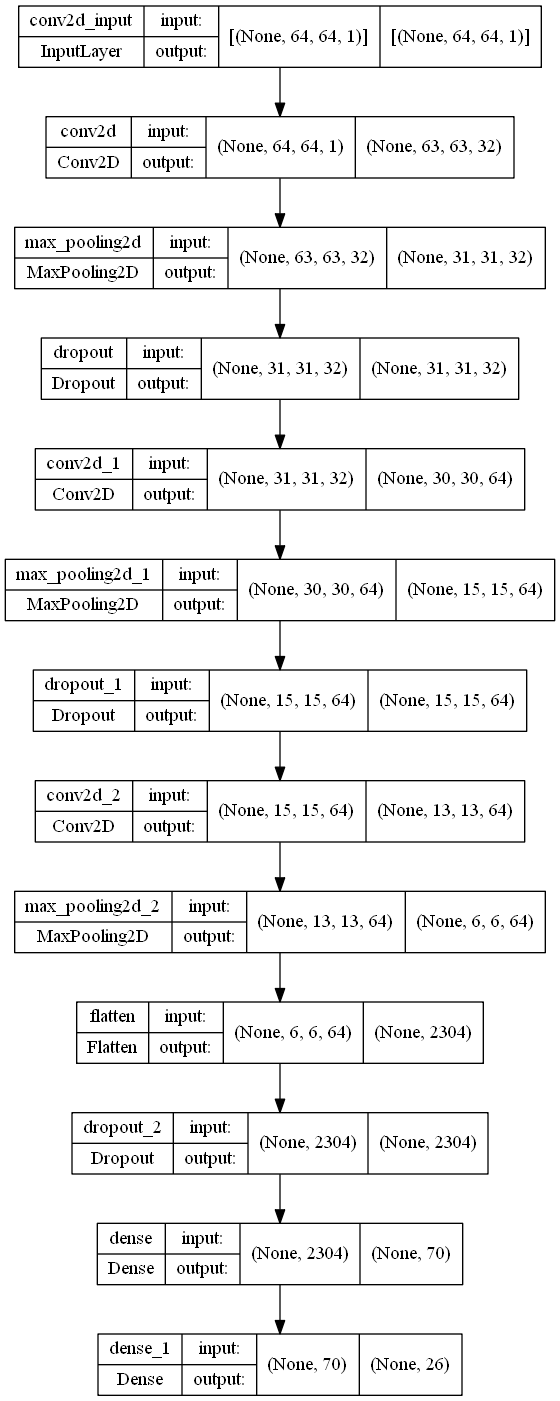

In [31]:
# model architecture

plot_model(model, show_shapes=True)

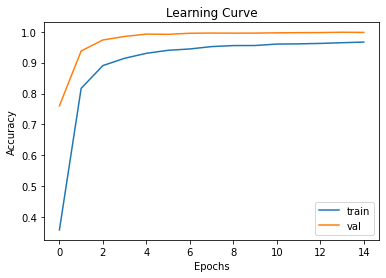

In [32]:
# Accuracy learning curve

plt.title("Learning Curve")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

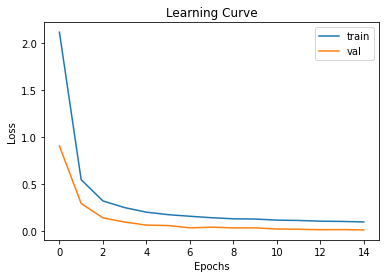

In [33]:
# Loss learning curve

plt.title("Learning Curve")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Testing

### Test data

In [34]:
# extracting files, images and labels 

test_path = r'C:\Users\dariu\Jupyter_Notebook\Sign Language Detection\sign_language_detection_dataset\test'

filename_list = []
image_list = []
label_list = []
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for label in labels:
    for filename in os.listdir(test_path+f'\\{label}'):
        file_path = test_path+f'\\{label}'+f'\\{filename}'
        letter = label
        image = cv2.imread(file_path)
        filename_list.append(filename)
        image_list.append(image)
        label_list.append(letter)

In [35]:
# creating meta dataset containing filenames, labels, and image

test_meta_data = pd.DataFrame({'filename':filename_list, 'label':label_list, 'image':image_list})
print(test_meta_data.shape)
test_meta_data.head()

(9464, 3)


,filename,label,image
0,1006.jpg,A,"[[[164, 167, 172], [164, 167, 172], [170, 170,..."
1,1013.jpg,A,"[[[167, 175, 174], [165, 173, 172], [166, 173,..."
2,1020.jpg,A,"[[[172, 170, 176], [170, 168, 174], [168, 166,..."
3,1027.jpg,A,"[[[168, 170, 171], [167, 169, 170], [169, 171,..."
4,103.jpg,A,"[[[186, 186, 180], [185, 185, 179], [187, 185,..."


In [36]:
# number of of samples per letter (category)

test_meta_data['label'].value_counts()

C    372
G    371
E    367
A    367
Z    366
K    366
S    365
H    364
F    364
T    364
D    363
P    363
O    363
U    363
R    363
Q    363
Y    363
J    363
L    362
B    362
M    362
W    362
I    362
X    362
N    361
V    361
Name: label, dtype: int64

In [37]:
test_meta_data.loc[test_meta_data['label']=='M']

,filename,label,image
4383,1006.jpg,M,"[[[188, 183, 192], [189, 184, 193], [181, 176,..."
4384,1013.jpg,M,"[[[184, 183, 185], [181, 180, 182], [181, 180,..."
4385,1020.jpg,M,"[[[176, 176, 176], [175, 175, 175], [175, 175,..."
4386,1027.jpg,M,"[[[183, 177, 182], [183, 177, 182], [179, 174,..."
4387,103.jpg,M,"[[[187, 184, 180], [188, 185, 181], [189, 186,..."
...,...,...,...
4740,971.jpg,M,"[[[176, 179, 177], [176, 179, 177], [178, 179,..."
4741,978.jpg,M,"[[[179, 178, 174], [179, 178, 174], [180, 180,..."
4742,985.jpg,M,"[[[176, 180, 175], [176, 180, 175], [176, 180,..."
4743,992.jpg,M,"[[[181, 181, 175], [180, 180, 174], [179, 179,..."


In [38]:
# shuffling meta dataset

test_meta_data =test_meta_data.sample(frac=1).reset_index(drop=True)
test_meta_data.head()

,filename,label,image
0,1699.jpg,C,"[[[165, 166, 170], [158, 159, 163], [162, 163,..."
1,1202.jpg,H,"[[[170, 173, 171], [170, 173, 171], [172, 175,..."
2,1118.jpg,W,"[[[168, 168, 168], [166, 166, 166], [166, 164,..."
3,2266.jpg,G,"[[[181, 182, 178], [181, 182, 178], [181, 183,..."
4,2462.jpg,U,"[[[180, 176, 175], [179, 175, 174], [178, 175,..."


In [39]:
preprocessed_image_list = []
error = []

for image in test_meta_data['image']:
    img = preprocess_image(image)
    preprocessed_image_list.append(img)

In [40]:
# splitting meta dataset into inputs and targets

X_test = np.array(preprocessed_image_list)

y_test = test_meta_data['label'] # adding number placeholders for each category
y_test = le.transform(y_test)

In [41]:
print(X_test.shape, y_test.shape)

(9464, 64, 64, 1) (9464,)


In [42]:
test_meta_data['preprocessed_image'] = preprocessed_image_list
test_meta_data.head()

,filename,label,image,preprocessed_image
0,1699.jpg,C,"[[[165, 166, 170], [158, 159, 163], [162, 163,...","[[[0.67058825], [0.6509804], [0.6627451], [0.6..."
1,1202.jpg,H,"[[[170, 173, 171], [170, 173, 171], [172, 175,...","[[[0.6745098], [0.6627451], [0.65882355], [0.6..."
2,1118.jpg,W,"[[[168, 168, 168], [166, 166, 166], [166, 164,...","[[[0.6509804], [0.6431373], [0.6431373], [0.63..."
3,2266.jpg,G,"[[[181, 182, 178], [181, 182, 178], [181, 183,...","[[[0.7137255], [0.7294118], [0.7490196], [0.74..."
4,2462.jpg,U,"[[[180, 176, 175], [179, 175, 174], [178, 175,...","[[[0.68235296], [0.7058824], [0.74509805], [0...."


In [43]:
# evaluating the model

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

296/296 - 1s - loss: 0.0166 - accuracy: 0.9981 - 745ms/epoch - 3ms/step


## Model Performance Metrics

In [44]:
y_pred_prob = model.predict(X_test) # returns an array containing probability for each category being output
y_pred = []
for i in y_pred_prob:
    out = np.argmax(i) # taking the highest probability category as output
    y_pred.append(out)
y_pred = np.array(y_pred)

In [45]:
# accuracy of the model

print(f'Accuracy :{round(accuracy_score(y_test, y_pred),4)*100}%')

Accuracy :99.81%


In [46]:
for i in range(len(y_test)):
    if y_pred[i]==13:
        print(i)

5
35
83
89
94
153
157
173
190
193
213
237
245
264
308
329
350
351
477
478
495
517
534
545
557
559
573
703
752
756
769
792
808
843
847
860
898
907
924
978
982
987
1001
1003
1011
1044
1049
1097
1099
1114
1115
1149
1150
1265
1286
1320
1365
1368
1390
1425
1533
1555
1606
1630
1644
1663
1675
1733
1738
1743
1762
1805
1863
1871
1875
1878
1896
1906
1913
1947
1966
1990
2110
2153
2182
2183
2199
2334
2349
2361
2366
2394
2405
2452
2456
2511
2527
2534
2543
2552
2569
2651
2657
2711
2719
2734
2881
2897
2940
2969
3059
3062
3106
3107
3130
3149
3158
3169
3178
3196
3207
3265
3291
3300
3317
3334
3357
3369
3398
3455
3470
3486
3507
3517
3524
3526
3539
3563
3566
3573
3582
3583
3585
3587
3618
3637
3654
3656
3705
3712
3735
3782
3897
3918
3996
4019
4038
4061
4085
4114
4122
4126
4128
4179
4293
4294
4305
4307
4360
4389
4390
4398
4440
4473
4478
4508
4512
4533
4596
4709
4720
4818
4822
4832
4841
4846
4911
4914
4917
4919
4942
4951
4980
5071
5095
5121
5132
5171
5189
5238
5239
5248
5304
5316
5344
5355
5365
5378
5384
541

In [47]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       367
           1       1.00      1.00      1.00       362
           2       1.00      1.00      1.00       372
           3       0.99      1.00      1.00       363
           4       1.00      1.00      1.00       367
           5       1.00      1.00      1.00       364
           6       1.00      1.00      1.00       371
           7       1.00      1.00      1.00       364
           8       1.00      1.00      1.00       362
           9       1.00      1.00      1.00       363
          10       0.99      1.00      1.00       366
          11       1.00      1.00      1.00       362
          12       1.00      0.99      1.00       362
          13       1.00      1.00      1.00       361
          14       1.00      1.00      1.00       363
          15       1.00      1.00      1.00       363
          16       0.99      1.00      1.00       363
          17       0.99    

<ipython-input-48-4b51091179d5>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Confusion Matrix', Fontsize=40)


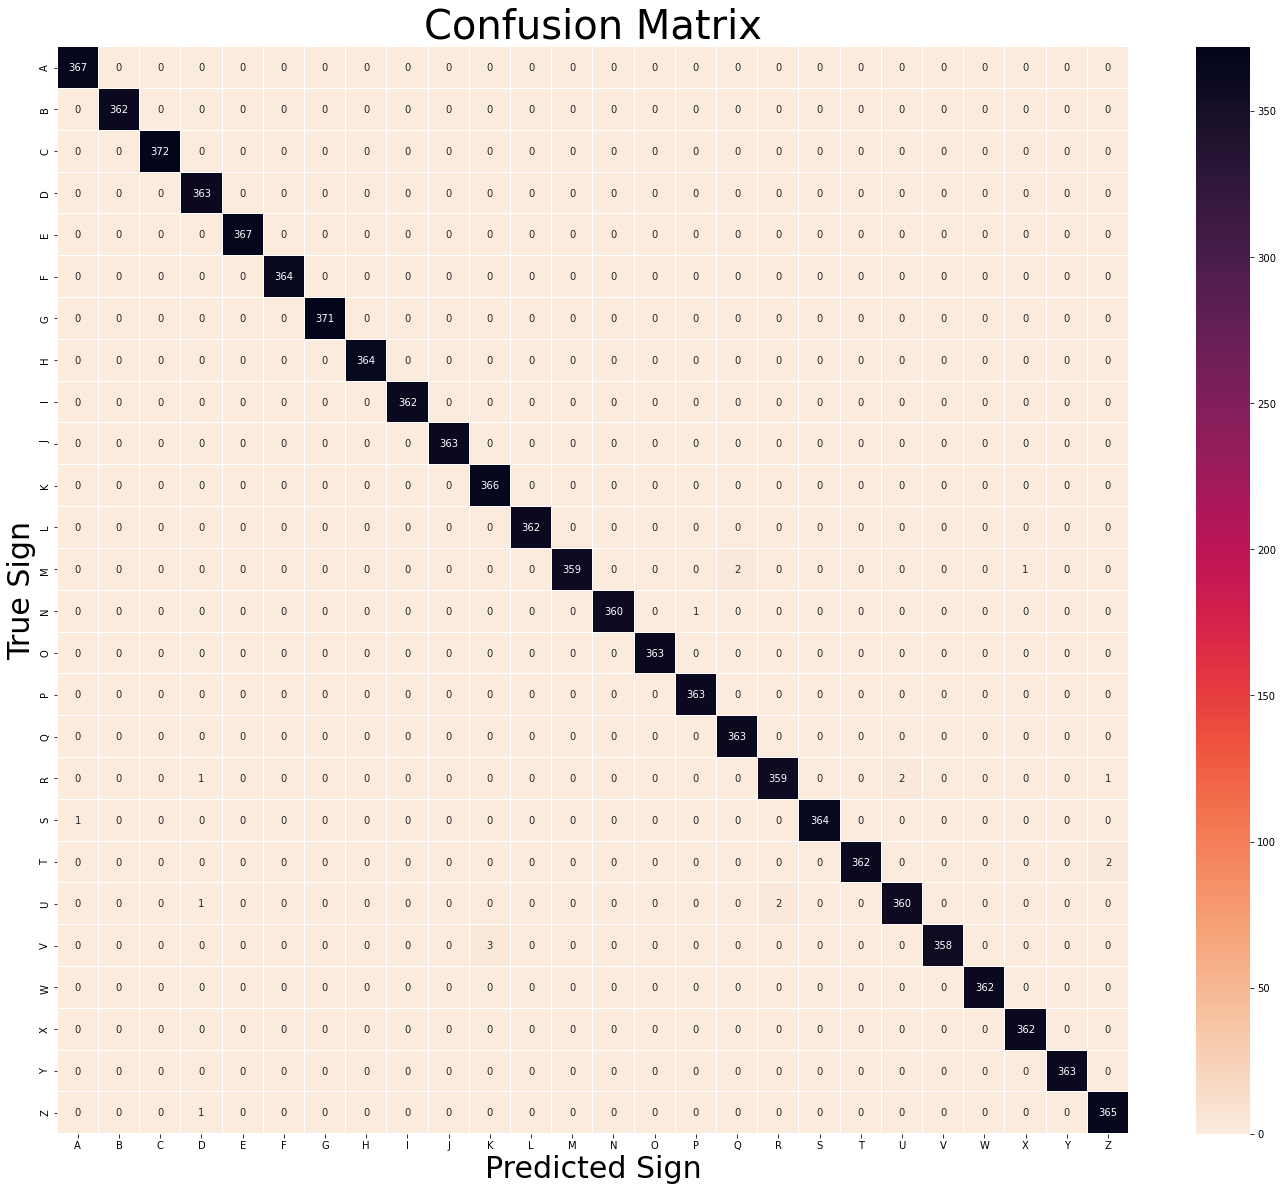

In [48]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred)

# heatmap of confusion matrix
plt.figure(figsize=(24,20))
plt.title('Confusion Matrix', Fontsize=40)
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='rocket_r', linecolor='white', linewidth=0.005, annot=True, fmt='d')
plt.xlabel('Predicted Sign', fontsize=30)
plt.ylabel('True Sign', fontsize=30)
plt.show()

## Saving the model for future use

In [62]:
# saving the model

model.save('sign_lang_detect_model.h5')

## Loading the model and predicting using the model

In [63]:
# loading the model 

model = load_model('sign_lang_detect_model.h5')

In [64]:
# function that preprocesses the data

def preprocess_image(image):
    """Takes in image array as input and returns resized and scaled image"""
    image = cv2.resize(image, (64,64))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(64,64,1)
    image = image.astype('float32')/255.0
    return image

In [65]:
# function that classifies image to detect sign

def classify(image):
    """
    takes image array as input and returns class of the output
    note: returns '' for 'nothing' and 'space' labels
    """
    image = preprocess_image(image)
    image = image.reshape(1,64,64,1)
    pred = model.predict([image])
    idx = np.argmax(pred)
    if idx == 26 or idx==27:
        return ""
    elif idx == 28:
        return " "
    else:
        return labels[idx]

In [66]:
# labels

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [67]:
# taking image as input and classifying it

test_image1 = cv2.imread(r'C:\Users\dariu\Jupyter_Notebook\Sign Language Detection\sign_language_detection_dataset\test\L\5.jpg')
classify(test_image1)

'L'

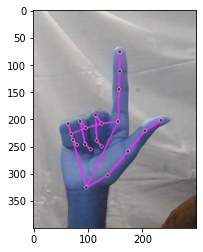

In [68]:
# image

plt.imshow(test_image1)

In [69]:
# taking image as input and classifying it

test_image2 = cv2.imread(r'C:\Users\dariu\Jupyter_Notebook\Sign Language Detection\sign_language_detection_dataset\test\H\12.jpg')
classify(test_image2)

'H'

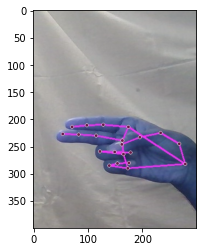

In [70]:
# image

plt.imshow(test_image2)

## Real-time sign language detection

In [58]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame

while True:
    ret, frame = cap.read()
    
    # sign language guide
    image2 = cv2.imread('ASL Sign Language.png')
    image2 = cv2.resize(image2,(1400,800))
    cv2.imshow('Guide', image2)
    
    frame = cv2.flip(frame, 1)
    top, right, bottom, left = 75, 350, 300, 590
    sign = frame[top:bottom, right:left]
    sign=cv2.flip(sign,1)
    cv2.imshow('Sign',sign)  # classification window
    alpha=classify(sign)  # classifying frame
    cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
    font=cv2.FONT_HERSHEY_SIMPLEX 
    cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
    cv2.imshow('img',frame)
    
    if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
        break
cap.release()
cv2.destroyAllWindows()

## Real time word and sentence detection

In [59]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame

i = 0
last_frame_alpha = None
sentence_list = []
sentence = ''

while True:
    ret, frame = cap.read()
    
    if ret==False:
        cap.release()
        break
    else:
        # sign language guide
        image2 = cv2.imread('ASL Sign Language.png')
        image2 = cv2.resize(image2,(1400,800))
        cv2.imshow('Guide', image2)

        frame = cv2.flip(frame, 1)
        top, right, bottom, left = 75, 350, 300, 590
        roi = frame[top:bottom, right:left]  # region of intrest
        roi=cv2.flip(roi,1)

        alpha=classify(roi)  # classifying frame
        cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
        font=cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
        cv2.imshow('img',frame)


        if last_frame_alpha==alpha:
            i+=1
        else:
            i=0

        if i>30 and alpha!="":
            print(alpha)
            sentence_list.append(alpha)
            sentence = "".join(sentence_list)
            i=0

        last_frame_alpha = alpha

        text_window = np.zeros((512, 512, 1), dtype = "uint8")
        text_window = cv2.resize(text_window, (1400, 220))
        cv2.putText(text_window, sentence,(0,130),font,3,(255,255,255),2)
        cv2.imshow('Text', text_window)

        if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
            cap.release()
            break

cv2.destroyAllWindows()
print("".join(sentence_list))

## Real time word and sentence detection with option to star/stop detection using 'space' key

In [60]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame

i = 0
last_frame_alpha = None
sentence_list = []
sentence = ''
detect=False

while True:
    ret, frame = cap.read()
    
    if cv2.waitKey(1) & 0xFF==ord(' '):
        detect = not detect
    
    if ret==False:
        cap.release()
        break
    else:
        if not detect:
            frame = cv2.flip(frame,1)
            cv2.imshow('img',frame)
        else:
            # sign language guide
            image2 = cv2.imread('ASL Sign Language.png')
            image2 = cv2.resize(image2,(1400,800))
            cv2.imshow('Guide', image2)

            frame = cv2.flip(frame, 1)
            top, right, bottom, left = 75, 350, 300, 590
            roi = frame[top:bottom, right:left]  # region of intrest
            roi=cv2.flip(roi,1)

            if cv2.waitKey(1) & 0xFF==ord(' '):
                detect=not detect

            alpha=classify(roi)  # classifying frame
            cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
            font=cv2.FONT_HERSHEY_SIMPLEX 
            cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
            cv2.imshow('img',frame)


            if last_frame_alpha==alpha:
                i+=1
            else:
                i=0

            if i>30 and alpha!="":
                print(alpha)
                sentence_list.append(alpha)
                sentence = "".join(sentence_list)
                i=0
            last_frame_alpha = alpha

            text_window = np.zeros((512, 512, 1), dtype = "uint8")
            text_window = cv2.resize(text_window, (1400, 220))
            cv2.putText(text_window, sentence,(0,130),font,3,(255,255,255),2)
            cv2.imshow('Text', text_window)

        if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
            cap.release()
            break


cv2.destroyAllWindows() 
print("".join(sentence_list))

## Sign language Detection with the ability to save frames to folder in directory

__Create an empty folder in directory called saved_frames.__

In [61]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame
sentence = ""

i = 0
last_frame_alpha = None
sentence_list = []
sentence = ''

while True:
    ret, frame = cap.read()
    
    if ret==False:
        cap.release()
        break
    else:
        # sign language guide
        image2 = cv2.imread('ASL Sign Language.png')
        image2 = cv2.resize(image2,(1400,800))
        cv2.imshow('Guide', image2)

        frame = cv2.flip(frame, 1)
        top, right, bottom, left = 75, 350, 300, 590
        roi = frame[top:bottom, right:left]  # region of intrest
        roi=cv2.flip(roi,1)
        cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
        cv2.imshow('img',frame)
        
        if cv2.waitKey(1) & 0xFF==ord(' '):
            i += 1
            alpha=classify(roi)  # classifying frame
            # cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
            font=cv2.FONT_HERSHEY_SIMPLEX 
            cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
            cv2.imshow('img',frame)
            cv2.imwrite(f'saved_frames\\{i}_{alpha}.jpg', frame)


            if alpha!="":
                print(alpha)
                sentence_list.append(alpha)
                sentence = "".join(sentence_list)
                

        font=cv2.FONT_HERSHEY_SIMPLEX
        text_window = np.zeros((512, 512, 1), dtype = "uint8")
        text_window = cv2.resize(text_window, (1400, 220))
        cv2.putText(text_window, sentence,(0,130),font,3,(255,255,255),2)
        cv2.imshow('Text', text_window)

        if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
            cap.release()
            break

cv2.destroyAllWindows()
print("".join(sentence_list))

B
W
Y
W
X
X
C
O
L
V
L
P
P
D
D
J
G
D
P
P
H
G
Z
G
BWYWXXCOLVLPPDDJGDPPHGZG
